### Building Chatbot with Multiple Tools using Langgraph


### Aim:- 
Create a chabot with tool with capabilities from arxiv,wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper 

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results = 2, doc_content_chars_max = 500)
arxiv = ArxivQueryRun(api_wrapper = api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv("Attention is all you need")

C:\Users\Mohan\AppData\Local\Temp\ipykernel_16020\2935370944.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  arxiv("Attention is all you need")


"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results = 2, doc_content_chars_max = 500)
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)
print(wiki.name)

wikipedia


In [6]:
wiki.invoke("What us Machine Learning?" )

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [ ]:
from dotenv import load_dotenv
load_dotenv()


import os 
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [9]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [12]:
tavily.invoke("Provide me the  recent AI news May 2025")

[{'title': 'Latest AI Breakthroughs and News: April- May 2025 - Crescendo.ai',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': "Date: May 2, 2025Summary: Recent research reveals a significant uptick in the adoption of artificial intelligence across manufacturing sectors. The study indicates that AI technologies are being increasingly utilized to optimize production processes, enhance quality control, and improve supply chain management, signaling a transformative shift in industrial operations.Source: PES Media\n\nUK Music Industry Expresses Concern Over AI Training Concessions [...] The Fresh and Interesting Artificial Intelligence News\n\nHere are all the impactful and latest AI breakthroughs that are shaping the world around us.Â\n\nUS Tech Giants Face New Challenge as Alibaba's Qwen3 Narrows the AI Gap\n\nDate: May 5, 2025Summary: Alibabaâ\x80\x99s latest AI model, Qwen3, significantly narrows the technology gap with leading US firms. Qwen3's advan

In [13]:
### Combine all the tools in the list
tools = [arxiv,wiki,tavily]

In [29]:
## Intialize my LLM Model
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen-qwq-32b")
llm_with_tools = llm.bind_tools(tools)

In [30]:
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage

llm_with_tools.invoke([HumanMessage(content = f"what is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'call_amed',
  'type': 'tool_call'}]

In [48]:
### State Schema 
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [ ]:
### Entire Chatbot with LangGraph
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END 
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition



##Node Defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]} 

In [ ]:
### Build Graph
builder  = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


## Add Edge
builder.add_edge(START,"tool_calling_llm")

builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


graph = builder.compile()

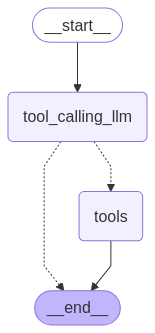

In [51]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
messages = graph.invoke({"messages":HumanMessage(content = "1706.03762")})


for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_ymhm)
 Call ID: call_ymhm
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [53]:
messages = graph.invoke({"messages":HumanMessage(content = "Provide me current News ?")})


for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me current News ?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_8pxa)
 Call ID: call_8pxa
  Args:
    query: current news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "CNN: Breaking News, Latest News and Videos", "url": "https://www.cnn.com/", "content": "View the latest news and breaking news today for U.S., world, weather, entertainment, politics and health at CNN.com.", "score": 0.98532}, {"title": "Fox News - Breaking News Updates | Latest News Headlines ...", "url": "https://www.foxnews.com/", "content": "Latest Breaking News Today from Fox News · FBI head Kash Patel issues fiery warning after mass shooting plot foiled - Fox News · Education secretary pours cold", "score": 0.98448}, {"title": "NBC News - Breaking News & Top Stories 

In [54]:
messages = graph.invoke({"messages":HumanMessage(content = "Provide me current News about the IPL ?")})


for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me current News about the IPL ?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_d81b)
 Call ID: call_d81b
  Args:
    query: latest news about IPL
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "IPL 2025 Latest News, Live Updates - NDTV Sports", "url": "https://sports.ndtv.com/ipl-2025/news", "content": "IPL 2025 News\n\nAfter a week-long suspension due to escalating tensions between Indian Premier League (IPL) 2025 is set to resume on May 17.\n\nRCB skipper Rajat Patidar was left \"sad\" and \"angry\" after being ignored by the franchise ahead of the IPL 2022 season despite assurances, only to be called up later as an injury replacement.\n\nRumours of Rajasthan Royals batter Vaibhav Suryavanshi failing the 10th standard board exams went vir